# 5. Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
%matplotlib inline

import prml.function as F
import prml.nn as nn

## 5.1 Feed-forward Network Functions

In [2]:
class FeedForwardNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        truncnorm = st.truncnorm(a=-2, b=2, scale=1)
        super().__init__(
            w1=truncnorm.rvs((n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2=truncnorm.rvs((n_hidden, n_output)),
            b2=np.zeros(n_output)
        )

    def __call__(self, x):
        h = nn.tanh(x @ self.w1 + self.b1)
        return h @ self.w2 + self.b2

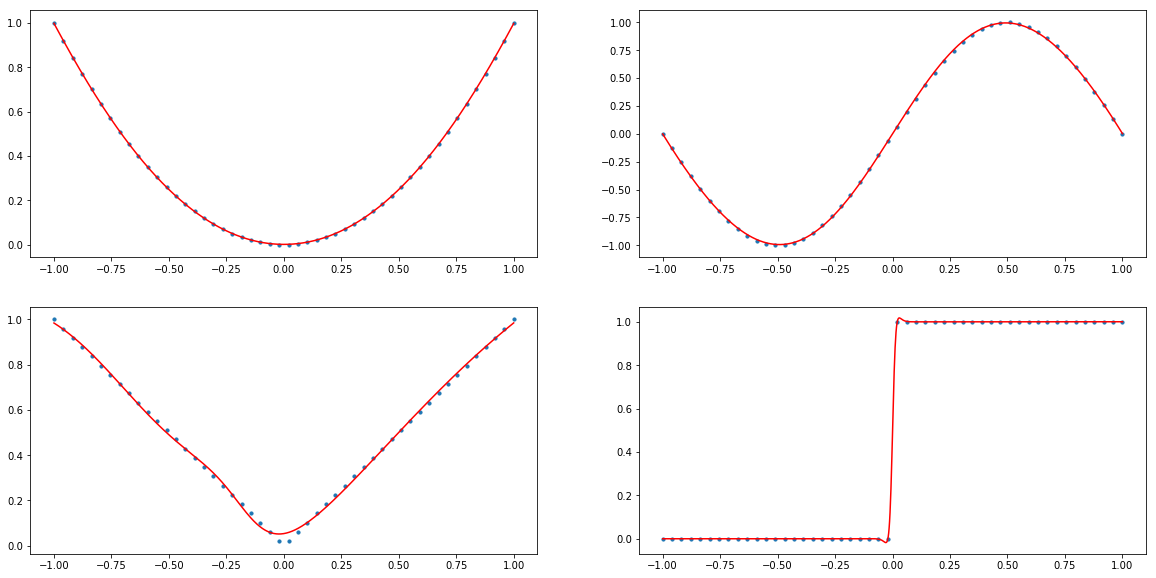

In [3]:
def create_toy_data(func, n=50):
    x = np.linspace(-1, 1, n)[:, None]
    return x, func(x)

def sinusoidal(x):
    return np.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

func_list = [np.square, sinusoidal, np.abs, heaviside]
plt.figure(figsize=(20, 10))
x = np.linspace(-1, 1, 1000)[:, None]
for i, func, n_iter, lr in zip(range(1, 5), func_list, [10000, 10000, 100000, 100000], [1e-2, 1e-2, 1e-4, 1e-3]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_toy_data(func)
    model = FeedForwardNetwork(1, 3, 1)
    optimizer = nn.optimizer.Adam(model, lr)
    for _ in range(n_iter):
        model.cleargrads()
        y = model(x_train)
        loss = F.sum_squared_error(y, y_train)
        loss.backward()
        optimizer.update()
    y = model(x).value
    plt.scatter(x_train, y_train, s=10)
    plt.plot(x, y, color="r")
plt.show()

## 5.3 Error Backpropagation

step      0, loss 74.399025
step  10000, loss 13.296480
step  20000, loss 8.837270
step  30000, loss 7.108446
step  40000, loss 6.225658
step  50000, loss 5.678355
step  60000, loss 5.292530
step  70000, loss 4.997869
step  80000, loss 4.761998
step  90000, loss 4.567949


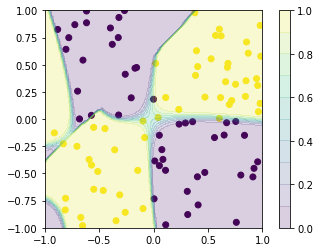

In [4]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2))
    labels = np.prod(x, axis=1) > 0
    return x, labels.reshape(-1, 1)


x_train, y_train = create_toy_data()
model = FeedForwardNetwork(2, 4, 1)
optimizer = nn.optimizer.Adam(model, 1e-3)

for i in range(100000):
    model.cleargrads()
    logit = model(x_train)
    loss = nn.sigmoid_cross_entropy(logit, y_train)
    if i % 10000 == 0:
        print("step %6d, loss %f" % (i, loss.value))
    loss.backward()
    optimizer.update()
    
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
logit = model(x)
y = nn.sigmoid(logit).value.reshape(100, 100)

levels = np.linspace(0, 1, 11)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y, levels, alpha=0.2)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 5.5 Regularization in Neural Networks

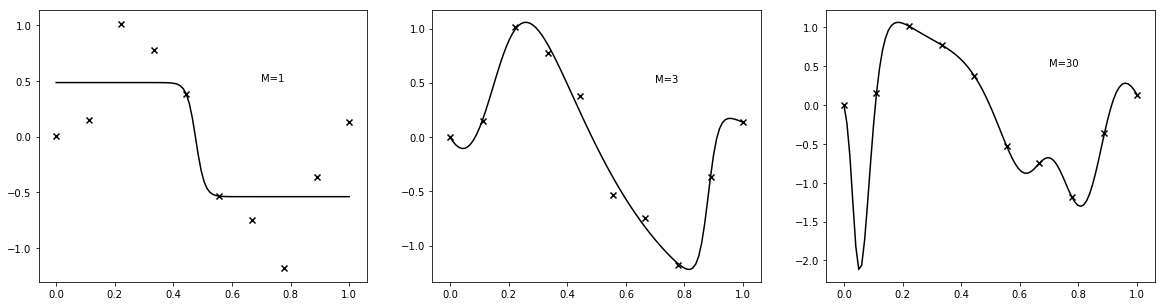

In [5]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)[:, None]
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1))


x_train, y_train = create_toy_data()
x = np.linspace(0, 1, 100)[:, None]

plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 30]):
    plt.subplot(1, 3, i + 1)
    model = FeedForwardNetwork(1, m, 1)
    optimizer = nn.optimizer.Adam(model)
    for j in range(100000):
        model.cleargrads()
        y = model(x_train)
        loss = F.sum_squared_error(y, y_train)
        loss.backward()
        optimizer.update()
    y = model(x).value
    plt.scatter(x_train, y_train, marker="x", color="k")
    plt.plot(x, y, color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

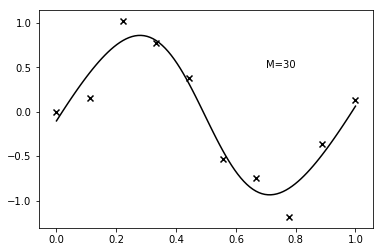

In [6]:
model = FeedForwardNetwork(1, 30, 1)
optimizer = nn.optimizer.Adam(model)
for i in range(100000):
    model.cleargrads()
    y = model(x_train)
    loss = F.sum_squared_error(y, y_train) + 1e-2 * nn.weight_decay(**model.params)
    loss.backward()
    optimizer.update()
y = model(x).value
plt.scatter(x_train, y_train, marker="x", color="k")
plt.plot(x, y, color="k")
plt.annotate("M=30", (0.7, 0.5))
plt.show()

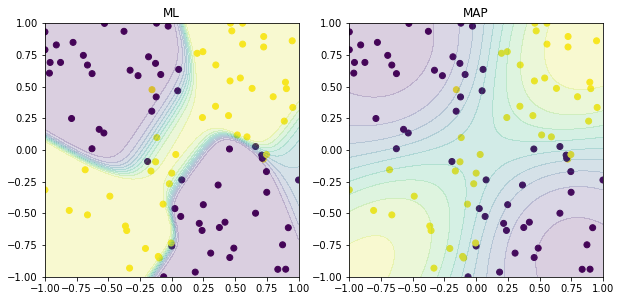

In [7]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2))
    labels = (np.prod(x, axis=1) > 0)
    x += np.random.normal(scale=0.1, size=(100, 2))
    np.clip(x, -1, 1, out=x)
    return x, labels.reshape(-1, 1)

x_train, y_train = create_toy_data()

model_ml = FeedForwardNetwork(2, 4, 1)
model_map = FeedForwardNetwork(2, 4, 1)

optimizer_ml = nn.optimizer.GradientDescent(model_ml, 1e-3)
optimizer_map = nn.optimizer.GradientDescent(model_map, 1e-3)

for i in range(100000):
    model_ml.cleargrads()
    model_map.cleargrads()
    logit_ml = model_ml(x_train)
    logit_map = model_map(x_train)
    loss_ml = nn.sigmoid_cross_entropy(logit_ml, y_train)
    loss_map = nn.sigmoid_cross_entropy(logit_map, y_train) + nn.weight_decay(**model_map.params)
    loss_ml.backward()
    loss_map.backward()
    optimizer_ml.update()
    optimizer_map.update()
    
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
y_mle = nn.sigmoid(model_ml(x)).value.reshape(100, 100)
y_map = nn.sigmoid(model_map(x)).value.reshape(100, 100)

levels = np.linspace(0, 1, 11)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y_mle, levels, alpha=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("ML")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y_map, levels, alpha=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("MAP")
plt.show()

In [8]:
def load_mnist():
    mnist = fetch_mldata("MNIST original")
    x = mnist.data
    label = mnist.target

    x = x / np.max(x, axis=1, keepdims=True)
    x = x.reshape(-1, 28, 28, 1)

    x_train, x_test, label_train, label_test = train_test_split(x, label, test_size=0.1)
    y_train = LabelBinarizer().fit_transform(label_train)
    return x_train, x_test, y_train, label_test
x_train, x_test, y_train, label_test = load_mnist()

In [9]:
class ConvolutionalNeuralNetwork(nn.Network):
    
    def __init__(self):
        truncnorm = st.truncnorm(a=-2, b=2, scale=0.1)
        super().__init__(
            w1=truncnorm.rvs((5, 5, 1, 20)),
            b1=np.zeros(20) + 0.1,
            w2=truncnorm.rvs((5, 5, 20, 20)),
            b2=np.zeros(20) + 0.1,
            w3=truncnorm.rvs((4 * 4 * 20, 500)),
            b3=np.zeros(500) + 0.1,
            w4=truncnorm.rvs((500, 10)),
            b4=np.zeros(10) + 0.1
        )
        
    def __call__(self, x):
        h = nn.relu(nn.convolve2d(x, self.w1) + self.b1)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))
        
        h = nn.relu(nn.convolve2d(h, self.w2) + self.b2)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))
        
        h = F.reshape(h, (-1, 4 * 4 * 20))
        h = nn.relu(h @ self.w3 + self.b3)
        
        return h @ self.w4 + self.b4


model = ConvolutionalNeuralNetwork()
optimizer = nn.optimizer.Adam(model, 1e-3)

while True:
    indices = np.random.permutation(len(x_train))
    for index in range(0, len(x_train), 50):
        model.cleargrads()
        x_batch = x_train[indices[index: index + 50]]
        y_batch = y_train[indices[index: index + 50]]
        logit = model(x_batch)
        loss = nn.softmax_cross_entropy(logit, y_batch)
        if optimizer.n_iter % 100 == 0:
            accuracy = accuracy_score(
                np.argmax(y_batch, axis=-1), np.argmax(logit.value, axis=-1)
            )
            print("step {:04d}".format(optimizer.n_iter), end=", ")
            print("accuracy {:.2f}".format(accuracy), end=", ")
            print("loss {:g}".format(loss.value))
        loss.backward()
        optimizer.update()
        if optimizer.n_iter == 10000:
            break
    else:
        continue
    break

step 0000, accuracy 0.18, loss 153.062
step 0100, accuracy 0.86, loss 19.6051
step 0200, accuracy 0.96, loss 4.75371
step 0300, accuracy 0.84, loss 14.6086
step 0400, accuracy 0.98, loss 4.97746
step 0500, accuracy 1.00, loss 2.12376
step 0600, accuracy 0.98, loss 4.11483
step 0700, accuracy 0.98, loss 5.47736
step 0800, accuracy 0.96, loss 5.40564
step 0900, accuracy 0.98, loss 3.67037
step 1000, accuracy 0.98, loss 4.30417
step 1100, accuracy 0.98, loss 2.98447
step 1200, accuracy 0.98, loss 3.62188
step 1300, accuracy 0.98, loss 1.89098
step 1400, accuracy 0.98, loss 1.56111
step 1500, accuracy 1.00, loss 0.345283
step 1600, accuracy 0.98, loss 2.27508
step 1700, accuracy 0.98, loss 1.46482
step 1800, accuracy 0.98, loss 1.09346
step 1900, accuracy 0.96, loss 5.04893
step 2000, accuracy 0.96, loss 3.51654
step 2100, accuracy 0.96, loss 2.301
step 2200, accuracy 0.98, loss 0.958537
step 2300, accuracy 1.00, loss 0.979826
step 2400, accuracy 0.98, loss 3.95238
step 2500, accuracy 0.98

In [10]:
label_pred = []
for i in range(0, len(x_test), 50):
    label_pred.append(np.argmax(model(x_test[i: i + 50]).value, axis=-1))
label_pred = np.asarray(label_pred).ravel()
print("accuracy (test):", accuracy_score(label_test, label_pred))

accuracy (test): 0.986142857143


## 5.6 Mixture Density Networks

In [11]:
def create_toy_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x, t

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_toy_data(func)

In [12]:
class MixtureDensityNetwork(nn.Network):
    
    def __init__(self, n_components):
        truncnorm = st.truncnorm(a=-0.2, b=0.2, scale=0.1)
        self.n_components = n_components
        super().__init__(
            w1=truncnorm.rvs((1, 5)),
            b1=np.zeros(5),
            w2=truncnorm.rvs((5, 3 * n_components)),
            b2=np.zeros(3 * n_components)
        )

    def __call__(self, x):
        h = nn.tanh(x @ self.w1 + self.b1)
        h = h @ self.w2 + self.b2
        a_weights, means, a_stds = F.split(h, (self.n_components, 2 * self.n_components))
        weights = nn.softmax(a_weights)
        stds = F.exp(a_stds)
        return weights, means, stds


def gaussian_mixture(target, weights, means, stds):
    gauss = F.exp(-0.5 * F.square((means - target) / stds)) / F.sqrt(2 * np.pi * F.square(stds))
    return F.sum(weights * gauss, axis=1)


def nll(prob):
    return -F.sum(F.log(prob))

In [13]:
model = MixtureDensityNetwork(3)
optimizer = nn.optimizer.Adam(model, 1e-4)

for i in range(30000):
    model.cleargrads()
    batch = sample(x_train, y_train, n=100)
    prob = gaussian_mixture(y_train, *model(x_train))
    loss = nll(prob)
    loss.backward()
    optimizer.update()

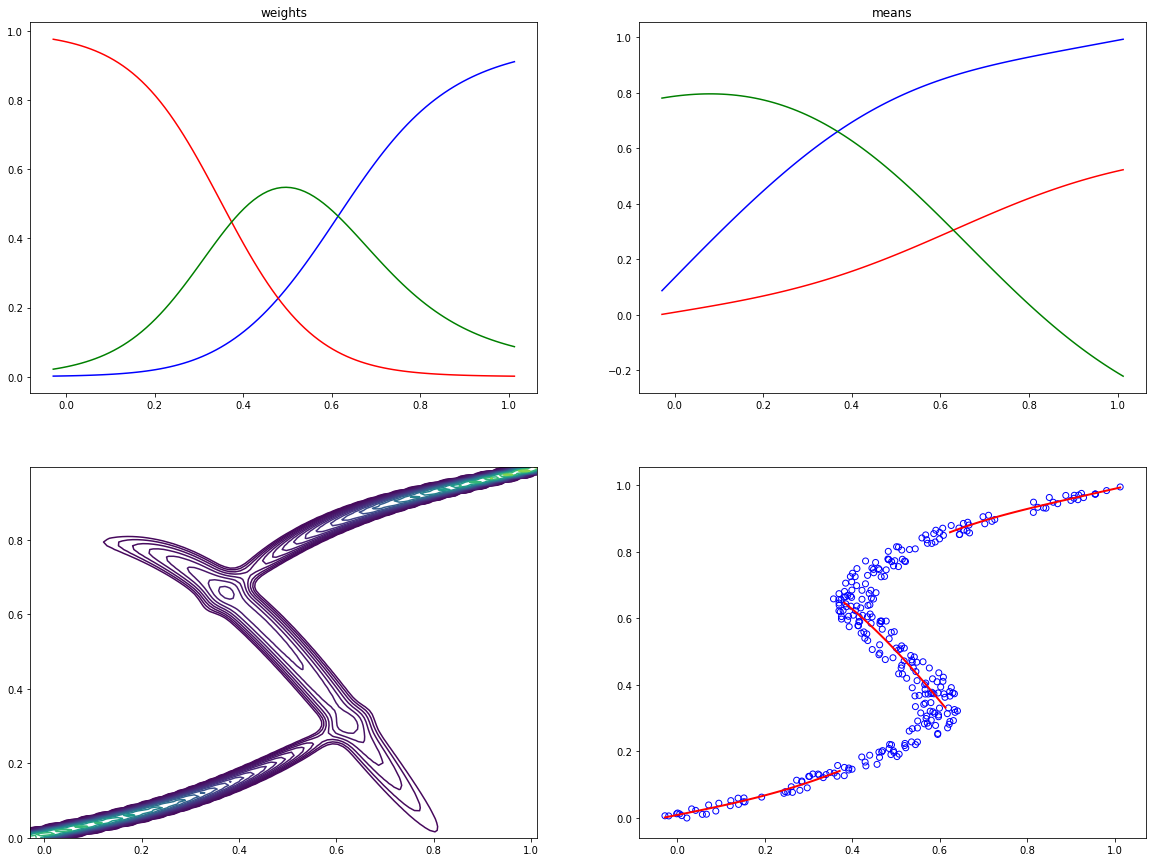

In [14]:
x, y = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
xy = np.array([x, y]).reshape(2, -1).T

weights, means, stds = model(xy[:, 0].reshape(-1, 1))
prob = gaussian_mixture(xy[:, 1].reshape(-1, 1), weights, means, stds).value.reshape(100, 100)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[0], weights.value[:100, 0], color="blue")
plt.plot(x[0], weights.value[:100, 1], color="red")
plt.plot(x[0], weights.value[:100, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[0], means.value[:100, 0], color="blue")
plt.plot(x[0], means.value[:100, 1], color="red")
plt.plot(x[0], means.value[:100, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
levels_log = np.linspace(0, np.log(prob.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
plt.contour(x, y, prob, levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(weights.value[:100], axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[0, indices], means.value[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()

## 5.7 Bayesian Neural Networks

Note that this is not the bayesian neural network explained in PRML

In [15]:
x_train = np.linspace(-3, 3, num=50)[:, None]
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=(50, 1))

In [16]:
class BayesianNeuralNetwork(nn.Network):
    
    def __init__(self):
        super().__init__(
            w0_m=np.zeros((1, 2)),
            w0_s=np.zeros((1, 2)),
            b0_m=np.zeros(2),
            b0_s=np.zeros(2),
            w1_m=np.zeros((2, 1)),
            w1_s=np.zeros((2, 1)),
            b1_m=np.zeros(1),
            b1_s=np.zeros(1)
        )

    def __call__(self, x):
        w0 = F.gaussian(self.w0_m, nn.softplus(self.w0_s))
        b0 = F.gaussian(self.b0_m, nn.softplus(self.b0_s))
        w1 = F.gaussian(self.w1_m, nn.softplus(self.w1_s))
        b1 = F.gaussian(self.b1_m, nn.softplus(self.b1_s))
        h = nn.tanh(x @ w0 + b0)
        return h @ w1 + b1
    
    
model = BayesianNeuralNetwork()
optimizer = nn.optimizer.GradientDescent(model, 1e-3)
n_iter = 10000
n_sample = 5
for i in range(n_iter):
    model.cleargrads()
    loss = 0
    for _ in range(n_sample):
        loss += 10 * F.sum_squared_error(model(x_train), y_train) / n_sample
    loss += F.gaussian_kl_divergence(model.w0_m, 0, nn.softplus(model.w0_s), 1).sum()
    loss += F.gaussian_kl_divergence(model.b0_m, 0, nn.softplus(model.b0_s), 1).sum()
    loss += F.gaussian_kl_divergence(model.w1_m, 0, nn.softplus(model.w1_s), 1).sum()
    loss += F.gaussian_kl_divergence(model.b1_m, 0, nn.softplus(model.b1_s), 1).sum()
    loss.backward()
    optimizer.update()

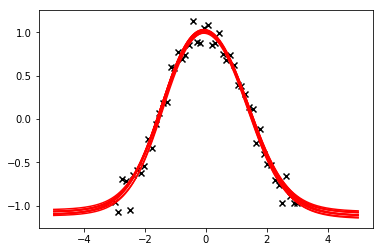

In [17]:
x = np.linspace(-5, 5, num=400)[:, None]
plt.scatter(x_train, y_train, marker="x", color="k")
for _ in range(10):
    plt.plot(x, model(x).value, color="r")
plt.show()